In [1]:
from ciml import gather_results
from ciml import tf_trainer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as pltcolors
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import collections
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from subunit2sql.db import api
from tensorflow.python.training import adagrad
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report

In [2]:
data_array = ['usr_1m-10s-node_provider;dnn-3x100-500epochs-bs128;e47805f2-e897-4b31-9b31-c2dfbd33fab9',
'usr_1m-10s-node_provider;dnn-3x1000-500epochs-bs128;4a98db93-1f2a-4764-80b7-4b5cc750cc19',
'usr_1m-30s-node_provider;dnn-3x100-500epochs-bs128;1b394383-7bfa-40c9-a5ce-ff83019ed3d9',
'usr_1m-30s-node_provider;dnn-3x1000-500epochs-bs128;eec60a78-de81-4fa8-a23f-b88991c192c4',
'usr_1m-1min-node_provider;dnn-3x100-500epochs-bs128;eeac358e-6f7a-4af0-aaca-7cff80dcbea4',
'usr_1m-1min-node_provider;dnn-3x1000-500epochs-bs128;7e3c2569-0729-4813-994c-45cdb85fc70a',
'usr_used-10s-node_provider;dnn-3x100-500epochs-bs128;2bf273a1-4245-4e85-a098-c9fba632c2b8',
'usr_used-10s-node_provider;dnn-3x1000-500epochs-bs128;0490f789-9190-4c0a-ae91-366334100e11',
'usr_used-30s-node_provider;dnn-3x100-500epochs-bs128;b8c14fec-ce4b-4f25-9414-7ff014f8cbc1',
'usr_used-30s-node_provider;dnn-3x1000-500epochs-bs128;52da2dc9-edba-4778-8cd4-c3a749f16f72',
'usr_used-1min-node_provider;dnn-3x100-500epochs-bs128;9905c3cd-2ef6-4680-814b-49dca7526657',
'usr_used-1min-node_provider;dnn-3x1000-500epochs-bs128;3add32f2-6ba7-48a4-af47-24bc92820ff3',
'usr_used_1m-10s-node_provider;dnn-3x100-500epochs-bs128;54b1916f-3f7e-4642-8259-48fc1a223c19',
'usr_used_1m-10s-node_provider;dnn-3x1000-500epochs-bs128;3a334391-00e0-4d82-bf45-6d4129ee2d6d',
'usr_used_1m-30s-node_provider;dnn-3x100-500epochs-bs128;b5515f79-74de-435f-a49d-4d41156c3131',
'usr_used_1m-30s-node_provider;dnn-3x1000-500epochs-bs128;24178274-5c5f-45b4-9d98-93a1b4a5f513',
'usr_used_1m-1min-node_provider;dnn-3x100-500epochs-bs128;747fa164-cde0-418f-b641-1b51976c037e',
'usr_used_1m-1min-node_provider;dnn-3x1000-500epochs-bs128;c2ace310-b089-40e5-84ca-2dbc5470425f',
'usr_1m-10s-status;dnn-5x100-500epochs-bs128;96c7f104-28f5-4a7b-b925-d7af6f8f0eab',
'usr_1m-1min-status;dnn-5x100-500epochs-bs128;ea60c7fd-c2bf-48f3-979f-52f53e731650']

In [4]:
#main_path = '/Users/andreafrittoli/ciml/cimlodsceu2019output'
main_path = '/Users/kw/ciml_data/output'
prediction_data_dict = {}
for data in data_array:
    dataset, experiment, runid = data.split(';')
    data_path = '/'.join([main_path, runid, 'data']) 
    file_name = 'prediction_' + dataset
    #Prediction_Data consists of EID, Pred, Class
    prediction_data_dict[(dataset, experiment)]= dict(prediction_data=gather_results.load_data_json(dataset, file_name,
        sub_folder=experiment, data_path=data_path)) 

In [5]:
#status_class_names = ['passed','failed']
status_class_names = [0,1]
multi_class_names = [x[:10] for x in 
                     ['ovh','rax','vexxhost',
                      'inap-mtl01','fortnebula-regionone',
                      'limestone-regionone','packethost-us-west-1']]

for de, pred in prediction_data_dict.items():
    prediction_data = pred['prediction_data']
    if prediction_data is None:
        continue
    pred_classes = [x[1]['classes'] for x in prediction_data]
    labels = [x[2] for x in prediction_data]
    if de[0].endswith('status'):
        pred['classes_norm'] = [int(x[0]) for x in pred_classes]  
        pred['labels_norm'] = labels
        pred['class_names_norm'] = status_class_names
    else:    
        pred['classes_norm'] = [x[0][:10] for x in pred_classes]    
        pred['labels_norm'] = [x[:10] for x in labels]
        pred['class_names_norm'] = multi_class_names

In [6]:
#Generates confusion matrix
for de,pred in prediction_data_dict.items():
    prediction_data = pred['prediction_data']
    if prediction_data is None:
        continue
    pred['confusion'] = confusion_matrix(pred['labels_norm'],pred['classes_norm'],labels=pred['class_names_norm'])

In [7]:
confusion = next(iter(prediction_data_dict.values()))['confusion']

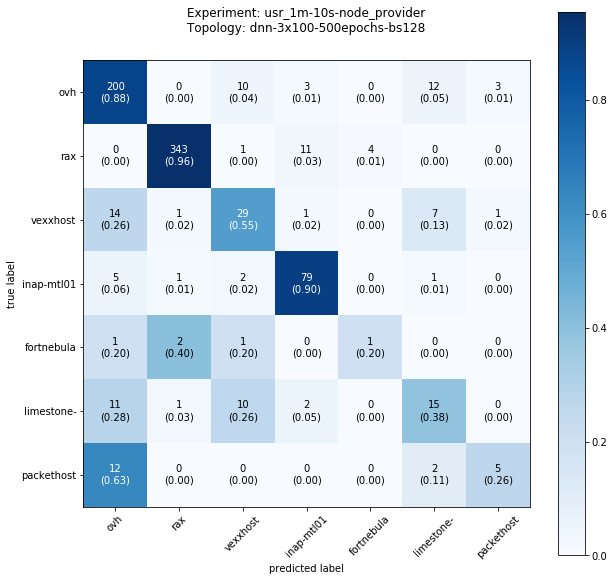

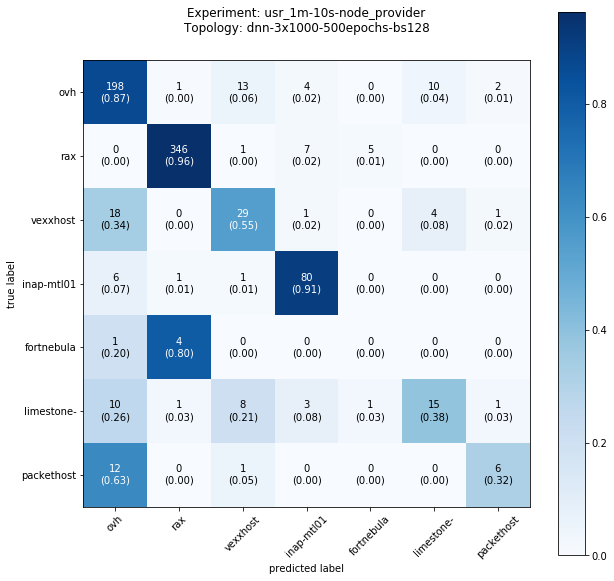

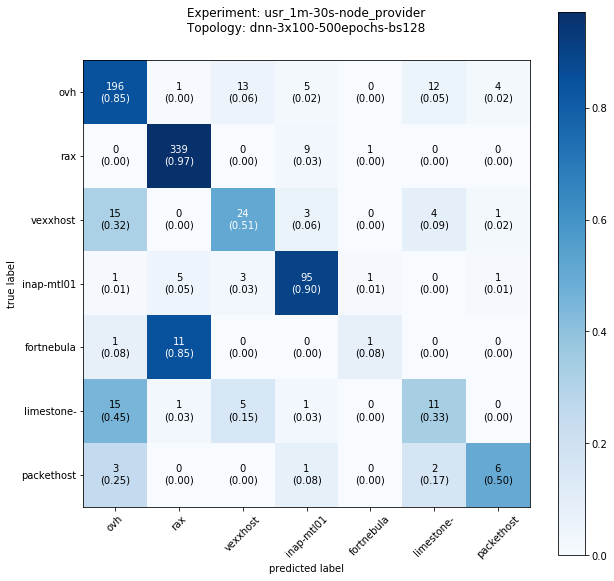

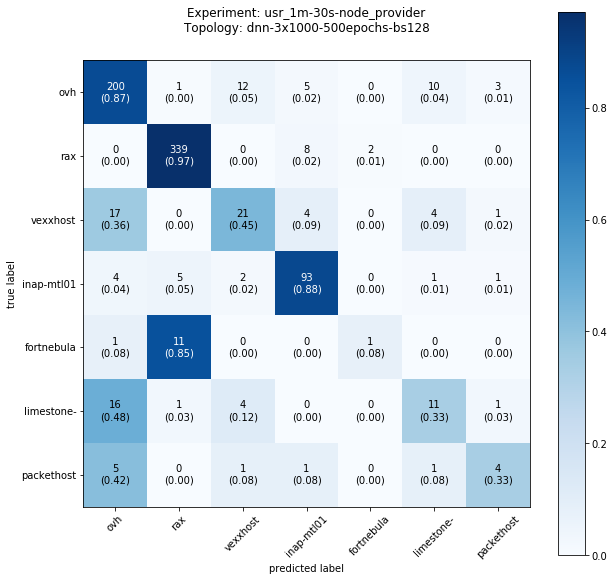

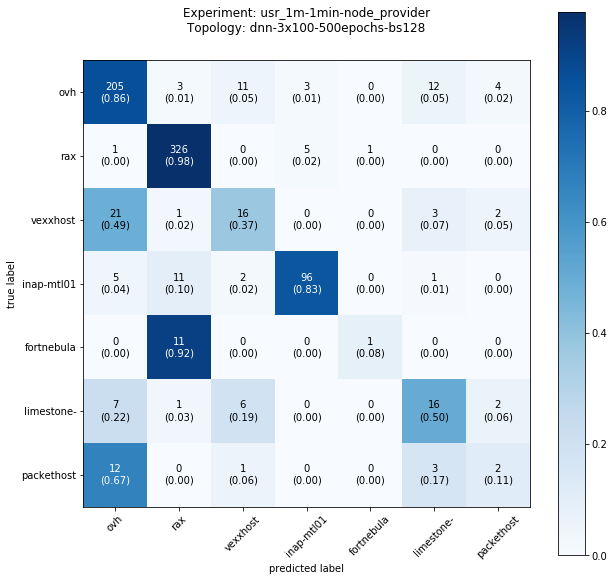

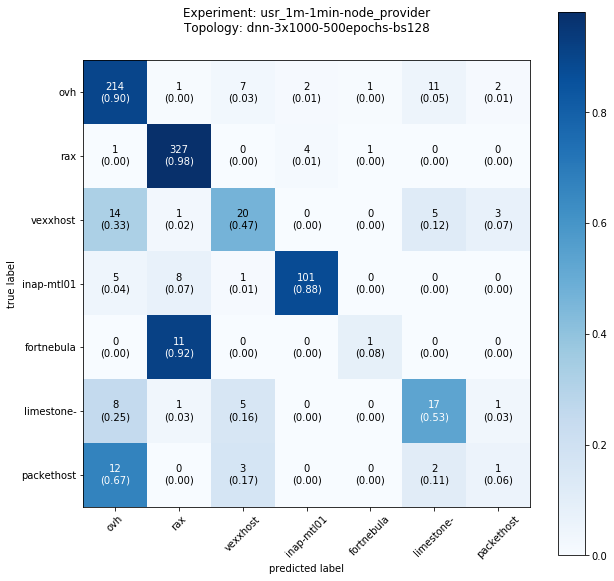

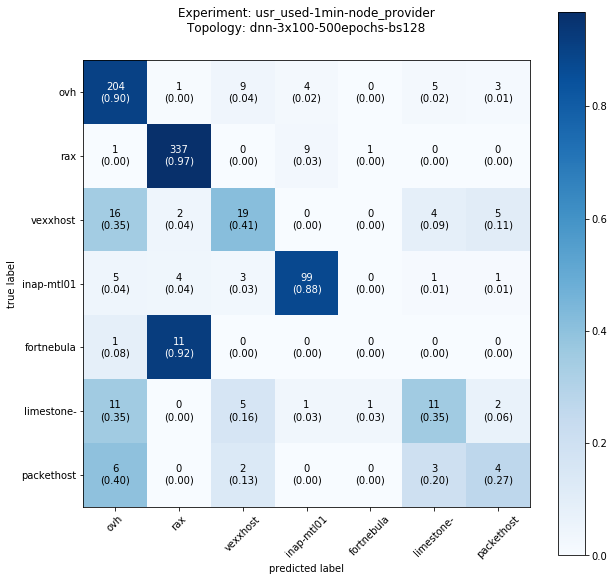

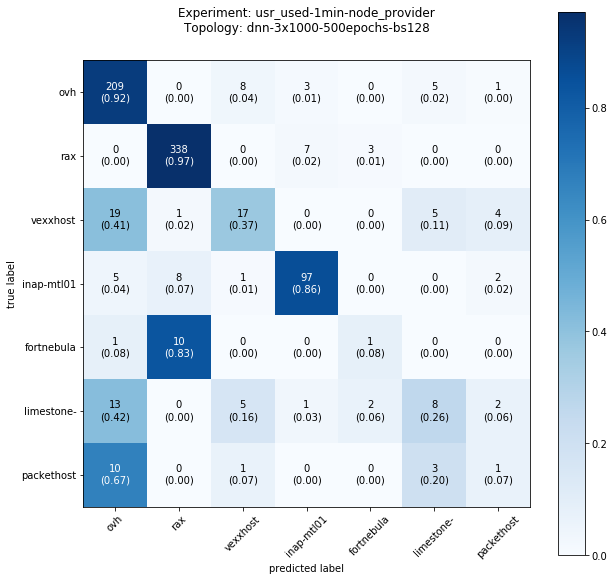

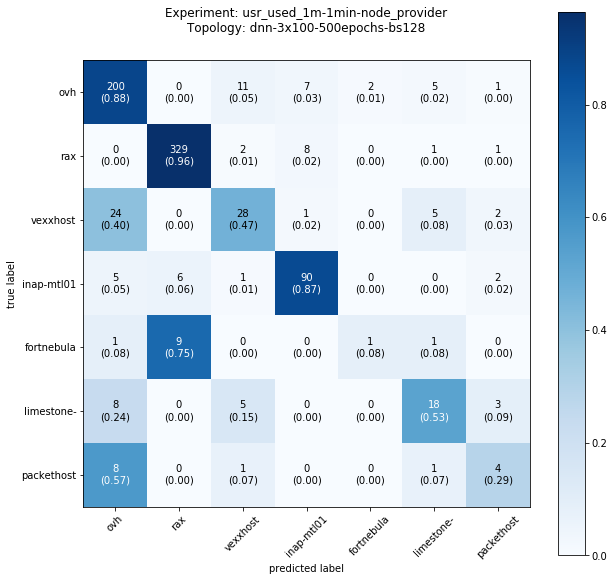

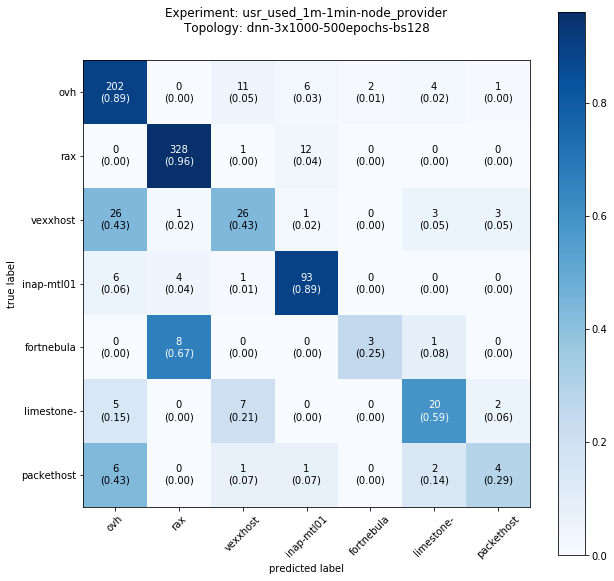

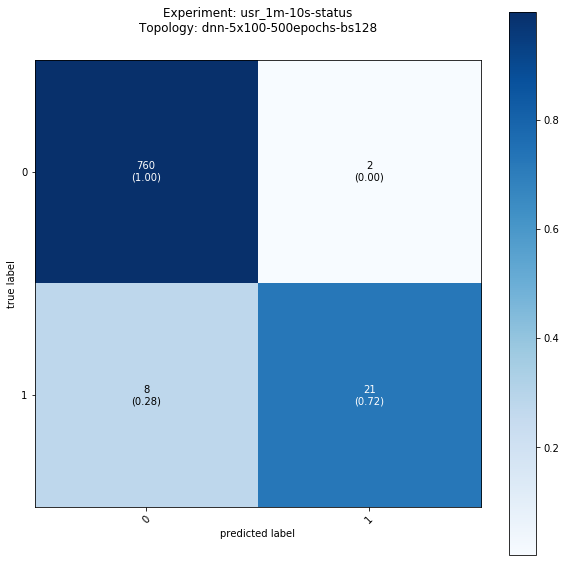

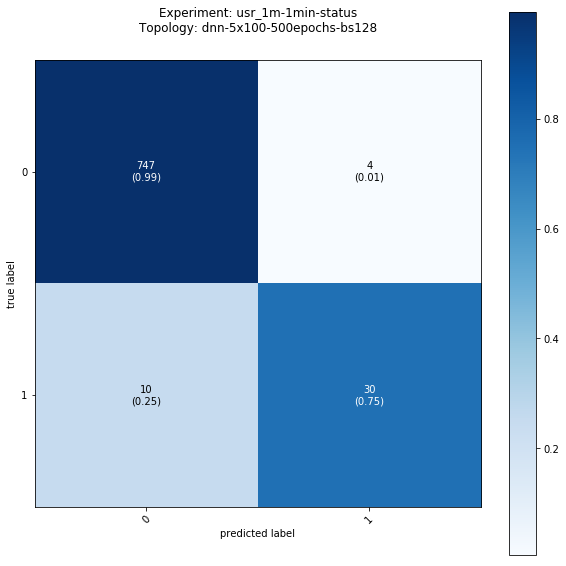

In [25]:
#Plots confusion matrix
#from matplotlib import rcParams
#rcParams.update({'figure.autolayout': True})

for de,pred in prediction_data_dict.items():
    prediction_data = pred['prediction_data']
    if prediction_data is None:
        continue        
    fig, ax = plot_confusion_matrix(conf_mat=pred['confusion'],
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True,
                                    figsize=(10,10),
                                    class_names=pred['class_names_norm'])
    plt.title('Experiment: ' + de[0] + '\n' + 'Topology: ' + de[1])
    fig.savefig(de[0] + de[1] + '_title_medium.png')
#data_plot.get_figure().savefig(output)
plt.show()

In [8]:
# Generate and print metrics report using sklearn
# sklearn.metrics.classification_report(y_true, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False)
#The precision is the ratio tp / (tp + fp).
#The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
#The recall is the ratio tp / (tp + fn). 
#The recall is intuitively the ability of the classifier to find all the positive samples.
#The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, 
#where an F-beta score reaches its best value at 1 and worst score at 0.
#The F-beta score weights recall more than precision by a factor of beta. 
#beta == 1.0 means recall and precision are equally important.
#F1 = 2 * (precision * recall) / (precision + recall)
#The support is the number of occurrences of each class in y_true.
for de,pred in prediction_data_dict.items():
    prediction_data = pred['prediction_data']
    if prediction_data is None:
        continue        
    #if not de[0].endswith('status'):
    pred['report'] = classification_report(pred['labels_norm'], pred['classes_norm'])
    print(de[0] + de[1] + '\n' + pred['report'])

usr_1m-10s-node_providerdnn-3x100-500epochs-bs128
              precision    recall  f1-score   support

  fortnebula       0.20      0.20      0.20         5
  inap-mtl01       0.82      0.90      0.86        88
  limestone-       0.41      0.38      0.39        39
         ovh       0.82      0.88      0.85       228
  packethost       0.56      0.26      0.36        19
         rax       0.99      0.96      0.97       359
    vexxhost       0.55      0.55      0.55        53

    accuracy                           0.85       791
   macro avg       0.62      0.59      0.60       791
weighted avg       0.85      0.85      0.85       791

usr_1m-10s-node_providerdnn-3x1000-500epochs-bs128
              precision    recall  f1-score   support

  fortnebula       0.00      0.00      0.00         5
  inap-mtl01       0.84      0.91      0.87        88
  limestone-       0.52      0.38      0.44        39
         ovh       0.81      0.87      0.84       228
  packethost       0.60      0.